In [1]:
from dateutil import parser
import requests
from decimal import Decimal
from functools import cache


# x = Decimal("53.548400")
# y = Decimal("10.0017195")
# r = 1900

url_base = "https://stadtrad.hamburg.de/"
url_path = "scs-search-and-book/"
url_suffix = "api/search/{x},{y},{r}".format


In [2]:
def stadtrad_session():
    s = requests.Session()
    s.get(url_base + url_path)
    s.get(url_base)
    return s


@cache
def stadtrad_payload(x, y, r, s):
    resp = s.get(url_base + url_path + url_suffix(x=x, y=y, r=r))
    assert "errors" not in resp.json(), resp.json()["errors"]
    assert resp.status_code == 200, resp.status_code
    return resp.json()["payload"]


In [3]:
s = stadtrad_session()

In [4]:
x = Decimal("53.5")
y = Decimal("10")
r = 100000

In [5]:
def radius49(x, y, s):
    r = 100000
    l = len(stadtrad_payload(x, y, r, s))
    while l >= 50 and r > 100:
        r = r // 10
        l = len(stadtrad_payload(x, y, r, s))    
    for i in range(int(math.log10(r)),-1,-1):
        for _ in range(10):
            while l < 50:
                r += 10**i
                l = len(stadtrad_payload(x, y, r, s))
        if l >= 50 and r > 100:
            r -= 10**i
            l = len(stadtrad_payload(x, y, r, s))
    return r


import math

r = radius49(x, y, s)
r

5600

In [6]:
payload = stadtrad_payload(x, y, r, s)
len(payload)

49

In [7]:
def offs(payload):
    lats = [Decimal(str(p["position"]["lat"])) for p in payload]
    lngs = [Decimal(str(p["position"]["lng"])) for p in payload]
    lat_off = max(lats) - min(lats)
    lng_off = max(lngs) - min(lngs)
    return lat_off, lng_off

lat_off,lng_off = offs(payload)

In [19]:
payload = stadtrad_payload(x, y, r, s)
positions = {(Decimal(str(p["position"]["lat"])), Decimal(str(p["position"]["lng"]))) for p in payload}

n1,n2 = 0,0
f1,f2 = 1,1

while True:
    print(n1,n2)
    r = radius49(x + f1*n1*lat_off, y + f2*n2*lng_off, s)
    payload = stadtrad_payload(x + n1*lat_off, y + f2*n2*lng_off, r, s)
    lat_off_new, lng_off_new = offs(payload)
    if lat_off_new < lat_off:
        print("new lat off", lat_off_new)
        lat_off = lat_off_new
        break
    if lng_off_new < lng_off:
        print("new lng off", lng_off_new)
        lng_off = lng_off_new
        break
    if {(p["position"]["lat"], p["position"]["lng"]) for p in payload} - positions == set():
        print("no more new stations")
        break
    positions |= {(p["position"]["lat"], p["position"]["lng"]) for p in payload}
    n1 += 1

2
3
4
5
6
7
8
9
10
no more new stations


In [16]:
for fac_lat in range(-5,2):
    for fac_lng in range(-1,2):
        temp = stadtrad_payload(s, x+fac_lat*lat_off, y+fac_lng*lng_off, r, False)
        print(len(temp))

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


In [42]:
def get_coords(payload):
    return {(Decimal(str(p["position"]["lat"])), Decimal(str(p["position"]["lng"]))) for p in payload}

In [43]:
payloads = [stadtrad_payload(s, x+fac_lat*lat_off, y+fac_lng*lng_off, r) for fac_lat in range(-1,2) for fac_lng in range(-1,2)]
payload_sum = [p for ps in payloads for p in ps]
coords_m1 = set(get_coords(payload_sum))
len(coords_m1)

154

In [44]:
coords_m2 = get_coords(stadtrad_payload(s, min([lat for lat,lng in get_coords(payload)]), max([lng for lat,lng in get_coords(payload)]), r))
len(coords_m2)

23

In [45]:
coords_m2 - coords_m1

{(Decimal('53.535202'), Decimal('10.024356'))}

In [46]:
payloads3 = list()

for fac_lat in range(-2,3):
    for fac_lng in range(-2,3):
        fac_lng += Decimal("0.5") * (fac_lat%2)
        payloads3 += stadtrad_payload(s, x+fac_lat*lat_off/2, y+fac_lng*lng_off/2, r)

print(len(payloads3))

579


In [48]:
set(get_coords(payload_sum)) - coords_m1

set()

100%|██████████| 24/24 [00:00<00:00, 42.28it/s]


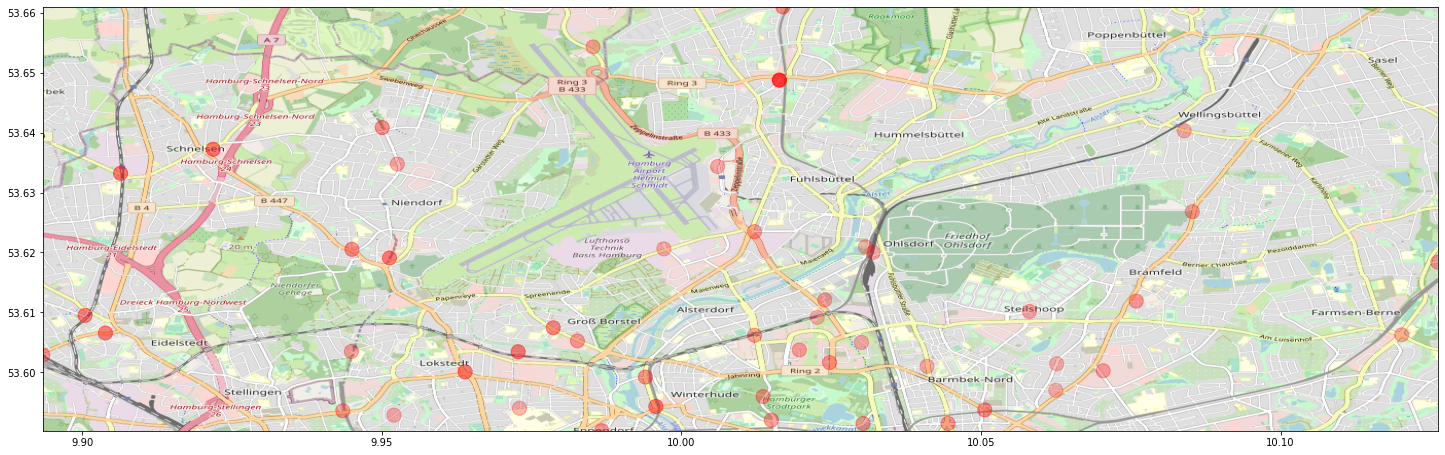

In [20]:
import numpy as np
import math
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from io import BytesIO
from itertools import product


URL = "https://tile.openstreetmap.org/{z}/{x}/{y}.png".format


@cache
def get_tile(x,y,z):
    return Image.open(BytesIO(requests.get(URL(x=x, y=y, z=z)).content))


def point_to_pixels(lon, lat, zoom, TILE_SIZE):
    """convert gps coordinates to web mercator"""
    r = math.pow(2, zoom) * TILE_SIZE
    lat = math.radians(lat)

    x = int((lon + 180.0) / 360.0 * r)
    y = int((1.0 - math.log(math.tan(lat) + (1.0 / math.cos(lat))) / math.pi) / 2.0 * r)

    return x, y

def plot_payload(payload, figsize=(25,16), s=200, c="red", TILE_SIZE = 256):
    bikes = np.array([p["rentalObjectCount"]["bike"] for p in payload])
    lats = np.array([p["position"]["lat"] for p in payload])
    lngs = np.array([p["position"]["lng"] for p in payload])
    
    top = np.max(lats)
    bot = np.min(lats)
    lef = np.min(lngs)
    rgt = np.max(lngs)
    
    for zoom in range(20,4,-1):
        x0, y0 = point_to_pixels(lef, top, zoom, TILE_SIZE)
        x1, y1 = point_to_pixels(rgt, bot, zoom, TILE_SIZE)

        x0_tile, y0_tile = int(x0 / TILE_SIZE), int(y0 / TILE_SIZE)
        x1_tile, y1_tile = math.ceil(x1 / TILE_SIZE), math.ceil(y1 / TILE_SIZE)

        total = (x1_tile - x0_tile) * (y1_tile - y0_tile)
        if total < 30:
            break
    
    img = Image.new(
        mode = 'RGB',
        size = (
            (x1_tile - x0_tile) * TILE_SIZE,
            (y1_tile - y0_tile) * TILE_SIZE
        )
    )

    # loop through every tile inside our bounded box
    for x_tile, y_tile in tqdm(product(range(x0_tile, x1_tile), range(y0_tile, y1_tile)), total=total):
        tile_img = get_tile(x=x_tile, y=y_tile, z=zoom)
        img.paste(
            im=tile_img,
            box=((x_tile - x0_tile) * TILE_SIZE, (y_tile - y0_tile) * TILE_SIZE)
        )
    
    x, y = x0_tile * TILE_SIZE, y0_tile * TILE_SIZE
    img = img.crop((
        int(abs(x - x0)),  # left
        int(abs(y - y0)),  # top
        int(abs(x - x1)),  # right
        int(abs(y - y1)),  # bottom
    ))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(
        x=lngs,
        y=lats,
        s=s,
        alpha=.25 + bikes/(2*np.max(bikes)),
        c=c
    )
    ax.imshow(img, extent=(lef, rgt, bot, top))

    ax.set_ylim(bot, top)
    ax.set_xlim(lef, rgt)
    
    return fig

fig = plot_payload(payload)